# Pair Trading

In [60]:
from data_process import Stock
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Parameter

In [61]:
threshold = 1
initial_invest = 10000
merge_threshold = 0.4
ticker1 = 'SPY'
ticker2 = 'QQQ'

# Get Stock

In [62]:
stock1 = Stock()
stock1_df = stock1.get_stock_data(ticker1, latest=3000)
stock1_df['Pct_change'] = stock1_df['Adj Close'].pct_change()
stock2 = Stock()
stock2_df = stock2.get_stock_data(ticker2, latest=3000)
stock2_df['Pct_change'] = stock2_df['Adj Close'].pct_change()
diff_df = pd.DataFrame()
diff_df['Date'] = stock2_df['Date']
diff_df['Pct_change'] = (stock1_df['Pct_change']-stock2_df['Pct_change'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Split train and test

In [63]:
train_size = int((len(diff_df)-1)*0.8)
train_df = diff_df[:train_size]
test_df = diff_df[train_size:]
train_df[ticker1] = stock1_df['Adj Close'][:train_size]
train_df[ticker2] = stock2_df['Adj Close'][:train_size]
test_df[ticker1] = stock1_df['Adj Close'][train_size:]
test_df[ticker2] = stock2_df['Adj Close'][train_size:]
print('Training size: {}'.format(len(train_df)))
print('Testing size: {}'.format(len(test_df)))

Training size: 1651
Testing size: 414


# Training: Calculate mean and std for threshold

In [64]:
variation = train_df['Pct_change'].values[1:]
var_mean = variation.mean()
var_std = variation.std()
train_df['Z_score'] = (train_df['Pct_change']-var_mean)/var_std

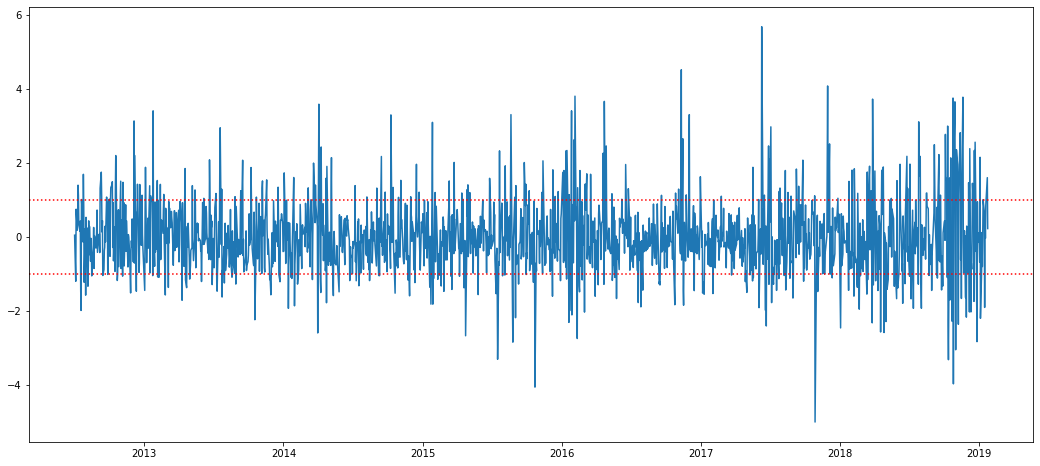

In [65]:
fig,ax = plt.subplots(figsize=(18,8))
plt.plot('Date','Z_score',data=train_df)
ax.axhline(y=threshold, color='r', ls='dotted')
ax.axhline(y=-threshold, color='r', ls='dotted')
plt.show()

# Training

In [66]:
sell_df = train_df[train_df['Z_score']>=threshold]
buy_df = train_df[train_df['Z_score']<=-threshold]

sell_stock1_df = pd.merge(train_df[['Date',ticker1]], sell_df, on=['Date',ticker1])
buy_stock2_df = pd.merge(train_df[['Date',ticker2]], sell_df, on=['Date',ticker2])

sell_stock2_df = pd.merge(train_df[['Date',ticker2]], buy_df, on=['Date',ticker2])
buy_stock1_df = pd.merge(train_df[['Date',ticker1]], buy_df, on=['Date',ticker1])

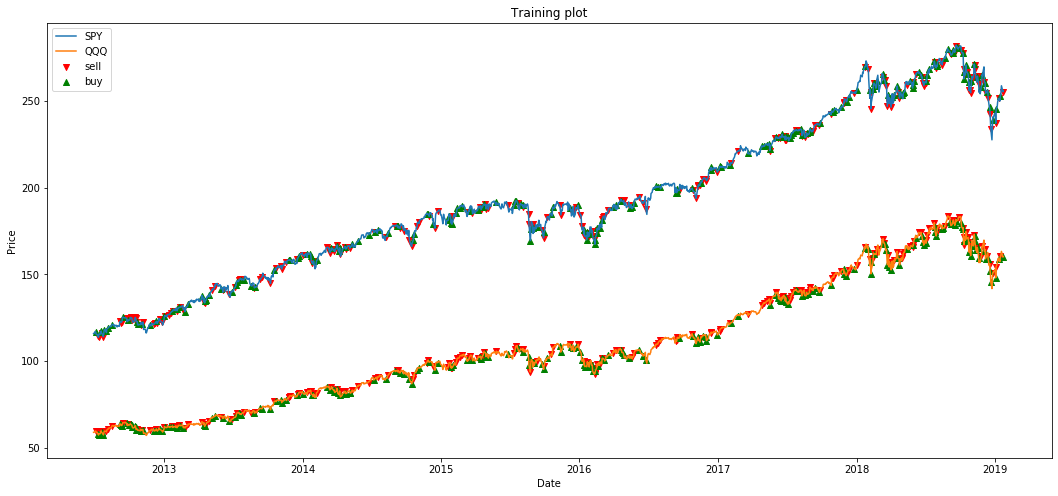

In [67]:
fig,ax = plt.subplots(figsize=(18,8))
plt.plot('Date',ticker1,data=train_df)
plt.plot('Date',ticker2,data=train_df)
plt.scatter(sell_stock1_df['Date'].values, sell_stock1_df[ticker1].values, color='red',marker='v',label='sell')
plt.scatter(sell_stock2_df['Date'].values, sell_stock2_df[ticker2].values, color='red',marker='v')
plt.scatter(buy_stock1_df['Date'].values, buy_stock1_df[ticker1].values, color='green',marker='^',label='buy')
plt.scatter(buy_stock2_df['Date'].values, buy_stock2_df[ticker2].values, color='green',marker='^')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Training plot')
plt.legend()
plt.show()

In [68]:
# buy and hold porfolio
price_stock1 = train_df[ticker1].values[0]
price_stock2 = train_df[ticker2].values[0]
amount_stock1 = initial_invest/2/price_stock1
amount_stock2 = initial_invest/2/price_stock2
print('{} price: {}. amount: {}.'.format(ticker1, price_stock1, amount_stock1))
print('{} price: {}. amount: {}.'.format(ticker2, price_stock2, amount_stock2))
portfolio = pd.DataFrame()
portfolio['Date'] = train_df['Date']
portfolio['{}_price'.format(ticker1)] = train_df[ticker1]
portfolio['{}_price'.format(ticker2)] = train_df[ticker2]
portfolio['Total_Hold'] = portfolio['{}_price'.format(ticker1)]*amount_stock1 + \
                            portfolio['{}_price'.format(ticker2)]*amount_stock2

SPY price: 115.9197998046875. amount: 43.1332697988132.
QQQ price: 58.87522506713867. amount: 84.92536536884953.


In [69]:
stock1_prices = train_df[ticker1].values
stock2_prices = train_df[ticker2].values
Z_scores = train_df['Z_score'].values
price_stock1 = stock1_prices[0]
price_stock2 = stock2_prices[0]
amount_stock1 = initial_invest/2/price_stock1
amount_stock2 = initial_invest/2/price_stock2
total = [initial_invest]
trade_watch = False
for i in range(1,len(train_df)):
    Z_score = Z_scores[i]
    price_stock1 = stock1_prices[i]
    price_stock2 = stock2_prices[i]
    if Z_score >= threshold: # sell stock1, buy stock2
        amount_stock2 += price_stock1 * amount_stock1 / price_stock2
        amount_stock1 = 0 
        trade_watch = True
    elif Z_score <= -threshold: # buy stock2, sell stock1
        amount_stock1 += price_stock2 * amount_stock2 / price_stock1
        amount_stock2 = 0
        trade_watch = True
    elif Z_score >= -merge_threshold and Z_score<= merge_threshold and trade_watch: # merge
        current_total = price_stock1*amount_stock1 + price_stock2*amount_stock2
        amount_stock1 = current_total/2/price_stock1
        amount_stock2 = current_total/2/price_stock2
        trade_watch = False
    total.append(price_stock1*amount_stock1 + price_stock2*amount_stock2)
portfolio['Total_Pair_Trade'] = pd.DataFrame(total, columns =['Total']) 

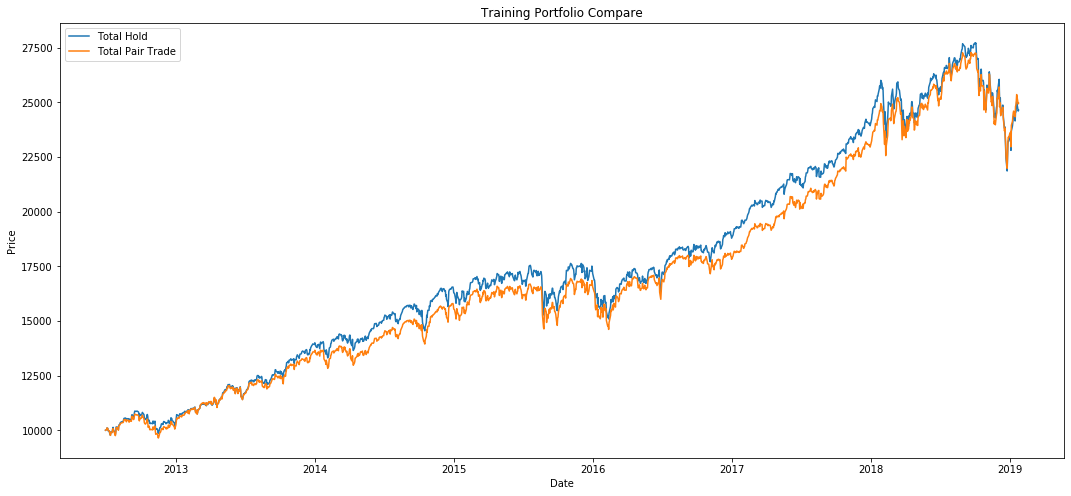

In [70]:
fig,ax = plt.subplots(figsize=(18,8))
plt.plot('Date','Total_Hold',data=portfolio,label='Total Hold')
plt.plot('Date','Total_Pair_Trade',data=portfolio,label='Total Pair Trade')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Training Portfolio Compare')
plt.legend()
plt.show()

In [71]:
benchmark_profit = portfolio['Total_Hold'].values[-1]/ portfolio['Total_Hold'].values[0]
pair_trade_profit = portfolio['Total_Pair_Trade'].values[-1]/ portfolio['Total_Pair_Trade'].values[0]
print('Benchmark Profit: {}'.format(benchmark_profit))
print('Pair Trade Profit: {}'.format(pair_trade_profit))

Benchmark Profit: 2.464222524796464
Pair Trade Profit: 2.4963225217163507


# Testing

In [72]:
test_df = test_df.reset_index(drop=True)
test_df['Z_score'] = (test_df['Pct_change']-var_mean)/var_std

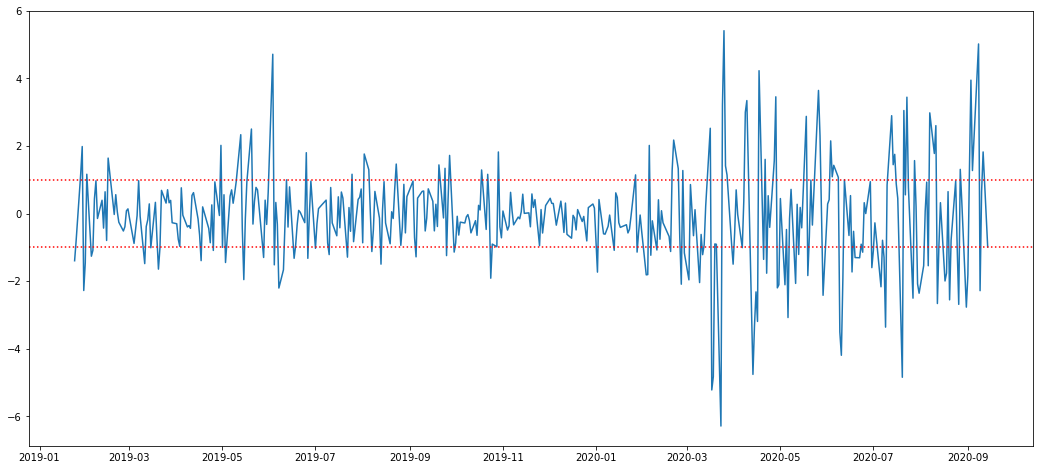

In [73]:
fig,ax = plt.subplots(figsize=(18,8))
plt.plot('Date','Z_score',data=test_df)
ax.axhline(y=threshold, color='r', ls='dotted')
ax.axhline(y=-threshold, color='r', ls='dotted')
plt.show()

# Testing

In [74]:
sell_df = test_df[test_df['Z_score']>=threshold]
buy_df = test_df[test_df['Z_score']<=-threshold]

sell_stock1_df = pd.merge(test_df[['Date',ticker1]], sell_df, on=['Date',ticker1])
buy_stock2_df = pd.merge(test_df[['Date',ticker2]], sell_df, on=['Date',ticker2])

sell_stock2_df = pd.merge(test_df[['Date',ticker2]], buy_df, on=['Date',ticker2])
buy_stock1_df = pd.merge(test_df[['Date',ticker1]], buy_df, on=['Date',ticker1])

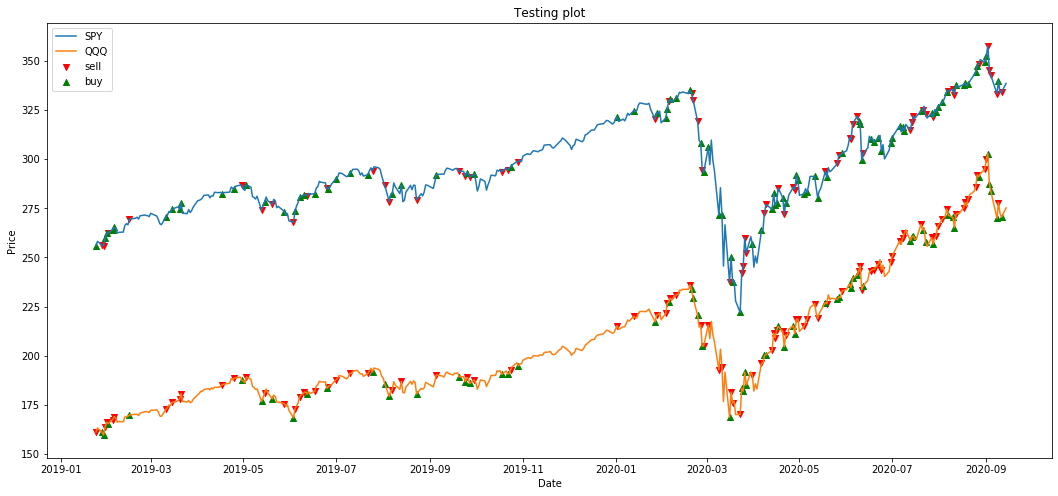

In [75]:
fig,ax = plt.subplots(figsize=(18,8))
plt.plot('Date',ticker1,data=test_df)
plt.plot('Date',ticker2,data=test_df)
plt.scatter(sell_stock1_df['Date'].values, sell_stock1_df[ticker1].values, color='red',marker='v',label='sell')
plt.scatter(sell_stock2_df['Date'].values, sell_stock2_df[ticker2].values, color='red',marker='v')
plt.scatter(buy_stock1_df['Date'].values, buy_stock1_df[ticker1].values, color='green',marker='^',label='buy')
plt.scatter(buy_stock2_df['Date'].values, buy_stock2_df[ticker2].values, color='green',marker='^')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Testing plot')
plt.legend()
plt.show()

In [76]:
# buy and hold porfolio
price_stock1 = test_df[ticker1].values[0]
price_stock2 = test_df[ticker2].values[0]
amount_stock1 = initial_invest/2/price_stock1
amount_stock2 = initial_invest/2/price_stock2
print('{} price: {}. amount: {}.'.format(ticker1, price_stock1, amount_stock1))
print('{} price: {}. amount: {}.'.format(ticker2, price_stock2, amount_stock2))
portfolio = pd.DataFrame()
portfolio['Date'] = test_df['Date']
portfolio['{}_price'.format(ticker1)] = test_df[ticker1]
portfolio['{}_price'.format(ticker2)] = test_df[ticker2]
portfolio['Total_Hold'] = portfolio['{}_price'.format(ticker1)]*amount_stock1 + \
                            portfolio['{}_price'.format(ticker2)]*amount_stock2

SPY price: 256.0135192871094. amount: 19.530218614715775.
QQQ price: 161.24147033691406. amount: 31.009392246005323.


In [77]:
stock1_prices = test_df[ticker1].values
stock2_prices = test_df[ticker2].values
Z_scores = test_df['Z_score'].values
price_stock1 = stock1_prices[0]
price_stock2 = stock2_prices[0]
amount_stock1 = initial_invest/2/price_stock1
amount_stock2 = initial_invest/2/price_stock2
total = [initial_invest]
trade_watch = False
for i in range(1,len(test_df)):
    Z_score = Z_scores[i]
    price_stock1 = stock1_prices[i]
    price_stock2 = stock2_prices[i]
    if Z_score >= threshold: # sell stock1, buy stock2
        amount_stock2 += price_stock1 * amount_stock1 / price_stock2
        amount_stock1 = 0 
        trade_watch = True
    elif Z_score <= -threshold: # buy stock2, sell stock1
        amount_stock1 += price_stock2 * amount_stock2 / price_stock1
        amount_stock2 = 0
        trade_watch = True
    elif Z_score >= -merge_threshold and Z_score<= merge_threshold and trade_watch: # merge
        current_total = price_stock1*amount_stock1 + price_stock2*amount_stock2
        amount_stock1 = current_total/2/price_stock1
        amount_stock2 = current_total/2/price_stock2
        trade_watch = False
    total.append(price_stock1*amount_stock1 + price_stock2*amount_stock2)
portfolio['Total_Pair_Trade'] = pd.DataFrame(total, columns =['Total']) 

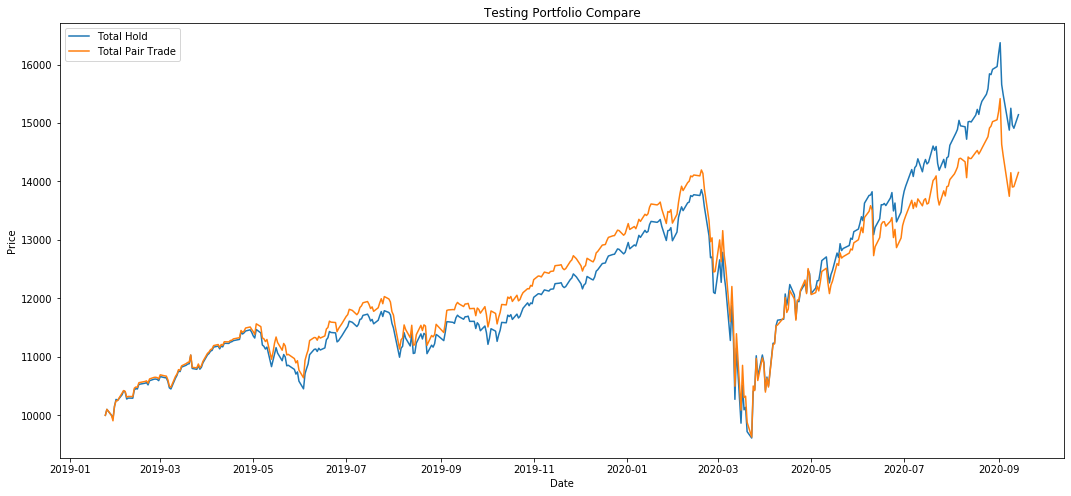

In [78]:
fig,ax = plt.subplots(figsize=(18,8))
plt.plot('Date','Total_Hold',data=portfolio,label='Total Hold')
plt.plot('Date','Total_Pair_Trade',data=portfolio,label='Total Pair Trade')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Testing Portfolio Compare')
plt.legend()
plt.show()

In [79]:
benchmark_profit = portfolio['Total_Hold'].values[-1]/ portfolio['Total_Hold'].values[0]
pair_trade_profit = portfolio['Total_Pair_Trade'].values[-1]/ portfolio['Total_Pair_Trade'].values[0]
print('Benchmark Profit: {}'.format(benchmark_profit))
print('Pair Trade Profit: {}'.format(pair_trade_profit))

Benchmark Profit: 1.514274210942312
Pair Trade Profit: 1.41543663353675
